# MNIST Image Detector

In [20]:
import numpy as np
import torch
from torch import flatten
import pandas as pd
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F

## Training Data

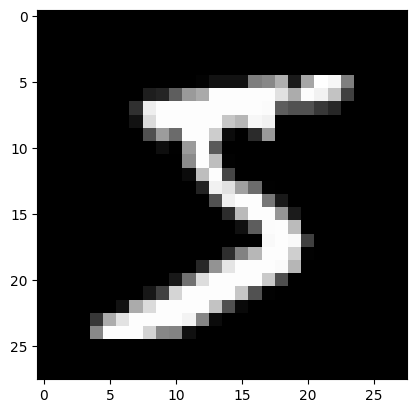

Number of images 60000
Image size: 28x28


In [21]:
with open("/Users/eminustun/Documents/Codes/Micrograd/MNIST_ORG/train-images.idx3-ubyte", "rb") as f:
    # Read magic number and metadata

    magic = int.from_bytes(f.read(4), 'big') # First 4 bytes are magic number ( A magic number in identifies file format)
    n_images = int.from_bytes(f.read(4), 'big') # Number of images
    n_rows = int.from_bytes(f.read(4), 'big') # number of rows
    n_cols = int.from_bytes(f.read(4), 'big') # number of columns

    # Read image data
    images = np.frombuffer(f.read(), dtype=np.uint8)
    images = images.reshape(n_images, n_rows, n_cols)

    plt.imshow(images[0], cmap="gray")
    plt.show()

print(f"Number of images {n_images}")
print(f"Image size: {n_rows}x{n_cols}")

In [22]:
print(images[0][5]) # Nasıl bir şey diye görmek istedim.

[  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
 175  26 166 255 247 127   0   0   0   0]


In [23]:
with open("/Users/eminustun/Documents/Codes/Micrograd/MNIST_ORG/train-labels.idx1-ubyte", "rb") as l:
    magic_label = int.from_bytes(l.read(4), byteorder='big')
    number_of_items = int.from_bytes(l.read(4), byteorder='big')
    labels = np.frombuffer(l.read(), dtype=np.uint8)

print(f"Number of labels: {number_of_items}")
print(f"Magic number: {magic_label}")
print(f"Labels are: {labels}")
print(f"First label is: {labels[0]}")

Number of labels: 60000
Magic number: 2049
Labels are: [5 0 4 ... 5 6 8]
First label is: 5


In [24]:
print(f"First Shapes: Images shape: {images.shape}")
print(f"First Shapes: Labels shape: {labels.shape}") # İkisinin de shape'i farklı olunca error veriyor.
'''
Images shape: (60000, 28, 28)
Labels shape: (60000,)
'''
images = torch.tensor(images, dtype=torch.float32).reshape(-1, 1, 28, 28)
# Örnek boyut dönüşümü:
# Başlangıç: (60000, 28, 28)
# Reshape sonrası: (60000, 1, 28, 28)
#   - 60000: görüntü sayısı
#   - 1: kanal sayısı (gri tonlama)
#   - 28, 28: görüntü boyutları
labels = torch.tensor(labels, dtype=torch.long)

print(f"Last Shapes: Images shape: {images.shape}")
print(f"Last Shapes: Labels shape: {labels.shape}") 

train_dataset = TensorDataset(images, labels)

First Shapes: Images shape: (60000, 28, 28)
First Shapes: Labels shape: (60000,)
Last Shapes: Images shape: torch.Size([60000, 1, 28, 28])
Last Shapes: Labels shape: torch.Size([60000])


In [25]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

## Test Data

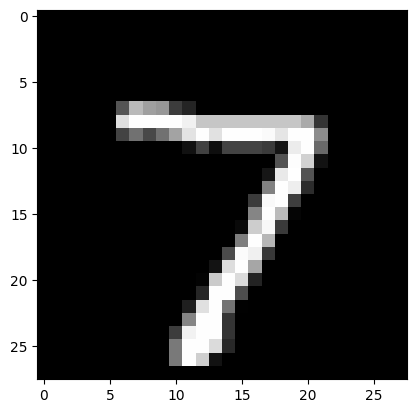

Number test of images 10000
Test image size: 28x28


In [26]:
with open("/Users/eminustun/Documents/Codes/Micrograd/MNIST_ORG/t10k-images.idx3-ubyte", "rb") as testD:
    # Read magic number and metadata
    test_data_magic = int.from_bytes(testD.read(4), 'big') # First 4 bytes are magic number ( A magic number in identifies file format)
    test_n_images = int.from_bytes(testD.read(4), 'big') # Number of images
    test_n_rows = int.from_bytes(testD.read(4), 'big') # number of rows
    test_n_cols = int.from_bytes(testD.read(4), 'big') # number of columns

    # Read image data
    test_images = np.frombuffer(testD.read(), dtype=np.uint8)
    test_images = test_images.reshape(test_n_images, test_n_rows, test_n_cols)

    plt.imshow(test_images[0], cmap="gray")
    plt.show()

print(f"Number test of images {test_n_images}")
print(f"Test image size: {test_n_rows}x{test_n_cols}")

In [27]:
print(test_images[0][7]) # Nasıl bir şey diye görmek istedim.

[  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [28]:
with open("/Users/eminustun/Documents/Codes/Micrograd/MNIST_ORG/t10k-labels.idx1-ubyte", "rb") as testL:
    test_magic_label = int.from_bytes(testL.read(4), byteorder='big')
    test_number_of_items = int.from_bytes(testL.read(4), byteorder='big')
    test_labels = np.frombuffer(testL.read(), dtype=np.uint8)

print(f"Number of labels: {test_number_of_items}")
print(f"Magic number: {test_magic_label}")
print(f"Labels are: {test_labels}")
print(f"First label is: {test_labels[0]}")

Number of labels: 10000
Magic number: 2049
Labels are: [7 2 1 ... 4 5 6]
First label is: 7


In [29]:
print(f"First Shapes: Images shape: {test_images.shape}")
print(f"First Shapes: Labels shape: {test_labels.shape}") # İkisinin de shape'i farklı olunca error veriyor.
'''
Images shape: (60000, 28, 28)
Labels shape: (60000,)
'''
test_images = torch.tensor(test_images, dtype=torch.float32).reshape(-1, 1, 28, 28)
test_labels = torch.tensor(test_labels, dtype=torch.long)

print(f"Last Shapes: Images shape: {test_images.shape}")
print(f"Last Shapes: Labels shape: {test_labels.shape}") 

test_dataset = TensorDataset(test_images, test_labels)

First Shapes: Images shape: (10000, 28, 28)
First Shapes: Labels shape: (10000,)
Last Shapes: Images shape: torch.Size([10000, 1, 28, 28])
Last Shapes: Labels shape: torch.Size([10000])


In [52]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Model

In [45]:
class MNISTNeuralNet(nn.Module):
    def __init__(self):
        super(MNISTNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 16 channels * 4 * 4 = 256
        self.fc1 = nn.Linear(16 * 4 * 4, 256)  # Düzeltilmiş boyut
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        c1 = F.relu(self.conv1(input))
        s2 = F.max_pool2d(c1, (2,2))
        c3 = F.relu(self.conv2(s2))
        s4 = F.max_pool2d(c3, 2)
        s4 = torch.flatten(s4, 1)  # flatten all dimensions except batch
        f5 = F.relu(self.fc1(s4))
        f6 = F.relu(self.fc2(f5))
        output = self.fc3(f6)
        return output

In [46]:
model = MNISTNeuralNet()
print(model)

MNISTNeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [47]:
params = list(model.parameters())
print(len(params))
print(params[0].size()) # conv1's weight

10
torch.Size([6, 1, 5, 5])


## Training and testing

In [48]:
def train_loop(dataloader, model,batch_size, loss_fn, optimizer):
    size = len(train_loader)
    model.train()

    for batch, (X, y) in enumerate(train_loader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f} [{current :>5d} | {size :>5d}]")


In [56]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

In [57]:
epochs = 10
for t in range(epochs):
  print(f"Epochs {t + 1}\n--------------------")
  train_loop(train_loader, model, 16, loss_fn, optimizer)
  test_loop(test_loader, model, loss_fn)
print("Done!")

Epochs 1
--------------------
loss: 0.019363 [   16 |  3750]
loss: 0.000410 [ 1616 |  3750]
loss: 0.000132 [ 3216 |  3750]
loss: 0.006616 [ 4816 |  3750]
loss: 0.001672 [ 6416 |  3750]
loss: 0.000109 [ 8016 |  3750]
loss: 0.000740 [ 9616 |  3750]
loss: 0.000609 [11216 |  3750]
loss: 0.000068 [12816 |  3750]
loss: 0.022536 [14416 |  3750]
loss: 0.002136 [16016 |  3750]
loss: 0.000013 [17616 |  3750]
loss: 0.002258 [19216 |  3750]
loss: 0.000597 [20816 |  3750]
loss: 0.002695 [22416 |  3750]
loss: 0.000529 [24016 |  3750]
loss: 0.008389 [25616 |  3750]
loss: 0.019450 [27216 |  3750]
loss: 0.000795 [28816 |  3750]
loss: 0.000569 [30416 |  3750]
loss: 0.005611 [32016 |  3750]
loss: 0.000746 [33616 |  3750]
loss: 0.000522 [35216 |  3750]
loss: 0.028733 [36816 |  3750]
loss: 0.000048 [38416 |  3750]
loss: 0.125090 [40016 |  3750]
loss: 0.001397 [41616 |  3750]
loss: 0.103635 [43216 |  3750]
loss: 0.000985 [44816 |  3750]
loss: 0.026442 [46416 |  3750]
loss: 0.000083 [48016 |  3750]
loss: 0.0

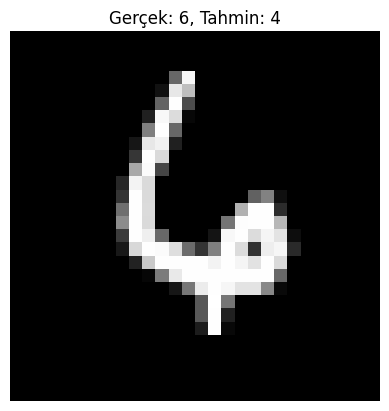

In [199]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = next(dataiter)

img = images[1]
label = labels[1]

model.eval()

with torch.no_grad():
    pred = model(img.unsqueeze(0))  # Batch boyutu eklemek için unsqueeze
    predicted = pred.argmax(1)

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f'Gerçek: {label.item()}, Tahmin: {predicted.item()}')
plt.axis('off')
plt.show()